*Major components of these lecture notes are based on the [Training a Classifier tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) in the PyTorch docs. It is recommended to run the code in these notes on Google Colab with a GPU enabled.*

<a href="https://colab.research.google.com/github/middlebury-csci-0451/CSCI-0451/blob/main/lecture-notes/convnets.ipynb" target="_parent">Open these notes in Google Colab</a>

<a href="https://colab.research.google.com/github/middlebury-csci-0451/CSCI-0451/blob/main/lecture-notes/convnets-live.ipynb" target="_parent">Open the live version in Google Colab</a>

## Introduction

The image classification problem is the problem of assigning a label to an image. For example, we might want to assign the label "duck" to pictures of ducks, the label "frog" to pictures of frogs, and so on. 

In more practical terms, we might be interested in classifications like: 

1. "**cancerous**" vs. "**noncancerous**" X-ray images. 
2. "**contains pedestrian**" vs. "**no pedestrian**" optical sensors in driver-assist vehicles. 
3. A recent problem that has come up: "**generated by human artist**" vs. "**generated by model**"

### Ethics of Image Classification

Image classification, and application of machine learning tools to visual data more generally, is an area fraught with ethical challenges. Just a few highlights of what can go wrong: 

1. The famous [GenderShades study](http://gendershades.org/) by Joy Buolamwini and Timnit Gebru found significant racial disparities in the accuracy of face-based gender classifiers. 
2. Researchers at Stanford [trained a model](https://www.theguardian.com/technology/2017/sep/07/new-artificial-intelligence-can-tell-whether-youre-gay-or-straight-from-a-photograph) on images from a dating site in order to make face-based predictions about an individual's sexual orientation, with higher-than-human accuracy. They argued that their paper supported the idea the sexual orientation is physiologically-influenced and therefore not a choice, but rather something that people are born with. On the other hand, critics raised concerns about the consequences of such a tool being used by oppressive governments in which queer identities and sexuality are prohibited and punished. 
3. A controversial study from 2016 claimed to be able to predict whether or not an individual would go on to commit a future crime from their facial features. In fact, the researchers allowed themselves to be fooled by a relic of their data collection process: their training data set of non-criminals was from online profile pictures (in which smiling is common), while their training data set of convicted criminals was mugshots, in which smiling is prohibited. So, they essentially built a smile-detector, which has some interest but not for the intended purpose. Here is [one writeup of this episode](https://www.newscientist.com/article/2114900-concerns-as-face-recognition-tech-used-to-identify-criminals/). The idea that it is possible to make inferences about a person's character, abilities, or future decisions is called [*physiognomy*](https://en.wikipedia.org/wiki/Physiognomy), and was one of the main "scientific" "justifications" of the scientific racism movement of the late 1800s and early 1900s. 



![](https://theintercept.imgix.net/wp-uploads/sites/1/2016/11/Screen-Shot-2016-11-18-at-12.09.50-PM.png?auto=compress%2Cformat&q=90&w=1000&h=857)

*Excerpted figure from the paper claiming to predict criminality from faces.*

## The CIFAR10 Data

For this lecture, we'll use the popular [CIFAR10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 was a common benchmark for simple image recognition tasks, although it's since been superseded by larger and more complex data sets.

To start, we'll load our packages, access the CIFAR10 data set, and set the device type. 

In [53]:
# if you don't have torchviz, install it by uncommenting and running the following line
# !pip install torchviz

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot, make_dot_from_trace
from torchsummary import summary

In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 27848414.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


If your computer has a CUDA GPU available, or if you are working on Google Colab, then you can use a GPU (CUDA) device on which to run your computations. This *can* be very helpful, often resulting in speedups of roughly 10x or so. However, how useful this is can depend strongly on the exact model architecture. Generally speaking, larger models will see greater benefits from GPU usage. 

### Visualizing The Data

The CIFAR10 training data set contains 50,000 images with 32x32 pixels and 3 color channels. Each of these images is labeled with one of 10 labels: 

In [56]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

The testing data set contains 10,000 more images with the same labels. 

Let's begin by visualizing a few elements of the training data set: 

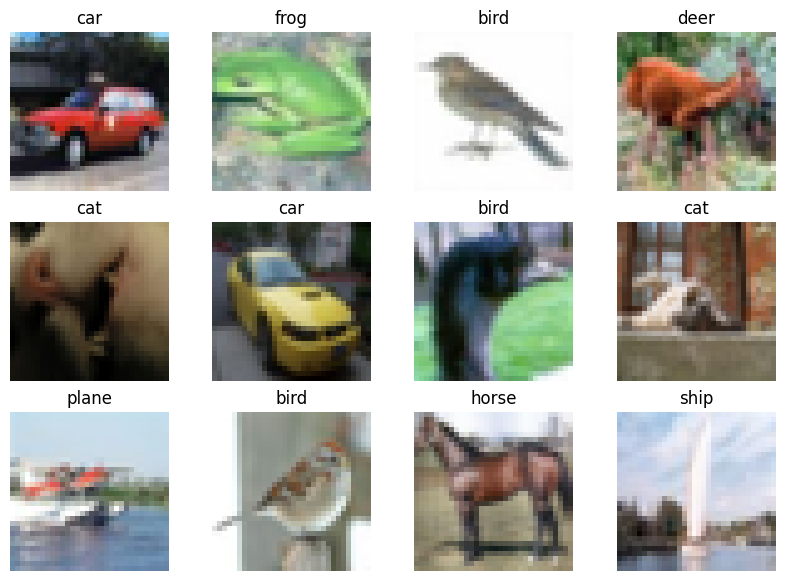

In [57]:
from matplotlib import pyplot as plt
import numpy as np

n_rows = 3

fig, axarr = plt.subplots(n_rows, batch_size, figsize = (10, 7))

tl = iter(trainloader)

for i in range(n_rows):

    # returns batch_size images with their labels
    X, y = next(tl) 

    # populate a row with the images in the batch
    for j in range(batch_size):
        img = np.moveaxis(X[j].numpy(), 0, 2) 
        axarr[i, j].imshow((img + 1)/2)
        axarr[i, j].axis("off")
        axarr[i, j].set(title = classes[int(y[j])])

Each of the 10 classes of data are evenly represented in the training and test data sets. So, the base rate for this problem (corresponding to random guessing) is 1/10 = 10%. 

## First Model: Logistic Regression

We're now ready to write some models to attempt do better than the base rate. Before we construct any models, we'll set our `device` to be equal to the GPU if we have one available (e.g. if your computer has one or if you are working on Google Colab. 

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Now let's construct a logistic regression model. All we need for this model is a `Linear` layer that accepts the number of floating point numbers used to store a single image and returns 10 numbers. A single image is a tensor of size $3\times32\times 32$, which means that it has 3072 total numbers stored. 

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class Logistic(nn.Module):
    def __init__(self):
        super().__init__()

        # matrix multiplication
        # 3072 is the flattened size of the image
        self.linear1 = nn.Linear(3072, 10)

    def forward(self, x):

        # flatten the image, converting it from 3x32x32 to 3072
        # the last dimension says "don't flatten across batches"
        # so each image stays distinct
        x = torch.flatten(x, 1)

        # do the matrix multiplication
        x = self.linear1(x)
        return x

# instantiate the model and move it to the device
model = Logistic().to(device)

We can get a nice summary of the structure of our model using the `summary` function from the `torchsummary` package: 

In [60]:
INPUT_SHAPE = (3, 32, 32)

summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]          30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


As a side note, after computing the loss on a bit of data, it's possible to actually visualize the computational graph. Fun! 

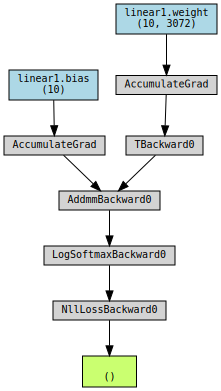

In [61]:
loss_fn = nn.CrossEntropyLoss() 

X, y = next(iter(trainloader))
X, y = X.to(device), y.to(device)

y_hat = model(X)
loss = loss_fn(y_hat, y)

make_dot(loss, params=dict(model.named_parameters()))


Let's go ahead and implement a training loop: 

In [62]:
import torch.optim as optim

def train(model, k_epochs = 1, print_every = 2000):

    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss() 

    # optimizer is Adam, which does fancier stuff with the gradients
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
                print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}')
                running_loss = 0.0

    print('Finished Training')

train(model, k_epochs = 2)

[epoch: 1, batches:  2000], loss: 2.344
[epoch: 1, batches:  4000], loss: 2.331
[epoch: 1, batches:  6000], loss: 2.330
[epoch: 1, batches:  8000], loss: 2.351
[epoch: 1, batches: 10000], loss: 2.296
[epoch: 1, batches: 12000], loss: 2.315
[epoch: 2, batches:  2000], loss: 2.247
[epoch: 2, batches:  4000], loss: 2.280
[epoch: 2, batches:  6000], loss: 2.306
[epoch: 2, batches:  8000], loss: 2.253
[epoch: 2, batches: 10000], loss: 2.311
[epoch: 2, batches: 12000], loss: 2.287
Finished Training


Let's also define a testing function that will evaluate the accuracy of our model against the test set. 

In [63]:
def test(model):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in testloader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            # run all the images through the model
            y_hat = model(X)

            # the class with the largest model output is the prediction
            _, predicted = torch.max(y_hat.data, 1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print(f'Test accuracy: {100 * correct // total} %')

test(model)

Test accuracy: 31 %


## Second Model: 1 Hidden Layer

Nothing at all wrong with this, but it's not very Deep. If all we wanted to do was logistic regression, we could have stuck with `scikit-learn` or even our own implementations. Here's an implementation of a linear-ReLU stack. This model has "complete" or "full" linkage because every unit in one layer is an input to every unit in the next layer. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/500px-Colored_neural_network.svg.png)

*Example of a a fully-connected neural network: every unit in every layer is an input into the next layer.*

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class Complete(nn.Module):
    def __init__(self):
        super().__init__()

        # the "hidden" layer: first dimension needs to have same size as 
        # data input
        # the number of "hidden units" is arbitrary but can affect model 
        # performance
        self.linear1 = nn.Linear(3072, 100)
        self.relu = nn.ReLU()

        # the output layer
        # first dimension needs to agree with final dimension from previous 
        # layer
        self.linear2 = nn.Linear(100, 10)

    # pass data through the layers in sequence
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model = Complete().to(device)

This time the number of model parameters is much larger: 

In [65]:
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]         307,300
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 10]           1,010
Total params: 308,310
Trainable params: 308,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.18
Estimated Total Size (MB): 1.19
----------------------------------------------------------------


Let's go ahead and train...

In [66]:
train(model, k_epochs=2)

[epoch: 1, batches:  2000], loss: 1.971
[epoch: 1, batches:  4000], loss: 1.796
[epoch: 1, batches:  6000], loss: 1.769
[epoch: 1, batches:  8000], loss: 1.729
[epoch: 1, batches: 10000], loss: 1.718
[epoch: 1, batches: 12000], loss: 1.704
[epoch: 2, batches:  2000], loss: 1.661
[epoch: 2, batches:  4000], loss: 1.673
[epoch: 2, batches:  6000], loss: 1.645
[epoch: 2, batches:  8000], loss: 1.652
[epoch: 2, batches: 10000], loss: 1.636
[epoch: 2, batches: 12000], loss: 1.655
Finished Training


...and test! 

In [67]:
test(model)

Test accuracy: 43 %


## Third Model: Convolutional Neural Net

Fully connected networks with hidden layers are *generalists*: they do their best to fit to the data using minimal assumptions about how the data is structured. For this reason, they are often decent at many tasks, but are often outperformed by networks with more specialized layeres that are adapted to the specifics of the task at hand. Image data, for example, is *spatial*. In order to address the spatial nature of images, it is useful to incorporate layers that explicitly account for spatial structure. 

One of the most common types of layers is a *convolutional* layer. The idea of an image convolution is pretty simple. We define a square *kernel matrix* containing some numbers, and we "slide it over" the input data. At each location, we multiply the data values by the kernel matrix values, and add them together. Here's an illustrative diagram:

![](https://d2l.ai/_images/correlation.svg)

*Image from [Dive Into Deep Learning](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)*

In this example, the value of 19 is computed as $0\times 0 + 1\times 1 + 3\times 2 + 4\times 3 = 19$. 

Historically, kernel matrices were designed by hand for specific purposes and applied to images. For example, here's a greyscale image alongside the result of convolving it with an *edge-detection kernel*. You can see that the resulting convolved image is darker (larger values in each pixel) in the places where different patches of color meet. 


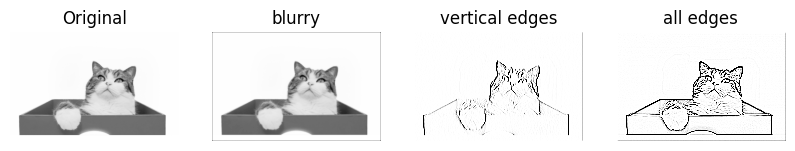

In [68]:
from PIL import Image
import urllib
from scipy.signal import convolve2d

# get the image
def read_image(url):
    return np.array(Image.open(urllib.request.urlopen(url)))

url = "https://i.pinimg.com/originals/0e/d0/23/0ed023847cad0d652d6371c3e53d1482.png"

img = read_image(url)

# convert it to greyscale
def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

img = to_greyscale(img)

# define some kernels

kernel1 = 1/9*np.array([[1, 1, 1], 
                        [1, 1, 1], 
                        [1, 1, 1]])

kernel2 = np.array([[-1, 2, -1], 
                    [-1, 2, -1], 
                    [-1, 2, -1]])

kernel3 = np.array([[-1, -1, -1], 
                    [-1,  8, -1], 
                    [-1, -1, -1]])

# prepare to visualize
labels = ["blurry", "vertical edges", "all edges"]

fig, axarr = plt.subplots(1, 4, figsize = (10, 6))

axarr[0].imshow(img, cmap = "Greys")
axarr[0].axis("off")
axarr[0].set(title = "Original")

# do kernel convolution. Some kernels need to be normalized in order to 
# generate good visuals
for i, kernel in enumerate([kernel1, kernel2, kernel3]):

    convd = convolve2d(img, kernel)

    if i == 0:
        vmin, vmax = 0, 1
        convd = (convd - np.min(convd)) / (np.max(convd) - np.min(convd))
    else: 
        vmin, vmax = 0, 10
    
    # visualize
    axarr[i+1].imshow(convd, cmap = "Greys", vmin = vmin, vmax = vmax)
    axarr[i+1].set(title = labels[i])
    viz = axarr[i+1].axis("off")
    

However, in the modern approach to learning from images, we don't both designing our own kernels. Instead, we *learn them* from the data! The reason this is possible is that the kernel convolution operation still corresponds to 

1. Multiplying some pairs of numbers together and
2. Adding up the products. 

Although the notation gets a little complicated, this is still just matrix multiplication!! So, we can represent convolutional layers within our framework just by carefully engineering these matrices. We won't worry about the details here, but instead will go straight into using convolutional layers in a model: 

In [100]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # first convolutional layer
        # 3 color channels, 100 different kernels, kernel size = 5x5
        self.conv1 = nn.Conv2d(3, 100, 5)

        # shrinks the image by taking the largest pixel in each 2x2 square
        self.pool = nn.MaxPool2d(2, 2)

        # MOAR CONVOLUTION
        # 100 channels (from previous kernels), 50 new kernels, kernel size = 3x3
        self.conv2 = nn.Conv2d(100, 50, 3)

        # EVEN MOAR CONVOLUTION
        self.conv3 = nn.Conv2d(50, 20, 3)

        # a few complete layers for good measure
        self.fc1 = nn.Linear(80, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):

        # these two layers use the spatial structure of the image
        # so we don't flatten yet
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # now we're ready to flatten all dimensions except batch
        x = torch.flatten(x, 1) 

        # pass results through fully connected linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)

What does max pooling do? you can think of it as a kind of "summarization" step in which we intentionally make the current output somewhat "blockier." Technically, it involves sliding a window over the current batch of data and picking only the largest element within that window. Here's an example of how this looks:

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

*Image credit: Computer Science Wiki*



Although convolutional neural networks seem more complicated, one of their key points is using a small set of kernels in each layer actually reduces the number of parameters when compared to a fully connected model. For example, our model here has more layers, but has fewer parameters than our previous model with a single hidden layer: 

In [101]:
summary(model, INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 28, 28]           7,600
         MaxPool2d-2          [-1, 100, 14, 14]               0
            Conv2d-3           [-1, 50, 12, 12]          45,050
         MaxPool2d-4             [-1, 50, 6, 6]               0
            Conv2d-5             [-1, 20, 4, 4]           9,020
         MaxPool2d-6             [-1, 20, 2, 2]               0
            Linear-7                   [-1, 80]           6,480
            Linear-8                   [-1, 40]           3,240
            Linear-9                   [-1, 10]             410
Total params: 71,800
Trainable params: 71,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.82
Params size (MB): 0.27
Estimated Total Size (MB): 1.11
---------------------------------------------

Furthermore, this model can obtain substantially better performance, because the parameters that it does have are designed for the spatial nature of the image classification task: 

In [102]:
train(model, k_epochs=2)

[epoch: 1, batches:  2000], loss: 1.976
[epoch: 1, batches:  4000], loss: 1.716
[epoch: 1, batches:  6000], loss: 1.607
[epoch: 1, batches:  8000], loss: 1.531
[epoch: 1, batches: 10000], loss: 1.474
[epoch: 1, batches: 12000], loss: 1.455
[epoch: 2, batches:  2000], loss: 1.369
[epoch: 2, batches:  4000], loss: 1.343
[epoch: 2, batches:  6000], loss: 1.329
[epoch: 2, batches:  8000], loss: 1.297
[epoch: 2, batches: 10000], loss: 1.267
[epoch: 2, batches: 12000], loss: 1.255
Finished Training


In [103]:
test(model)

Test accuracy: 55 %


Let's go ahead and take a look at some of the model predictions. We'll show the image, the true label, and the model's prediction. 

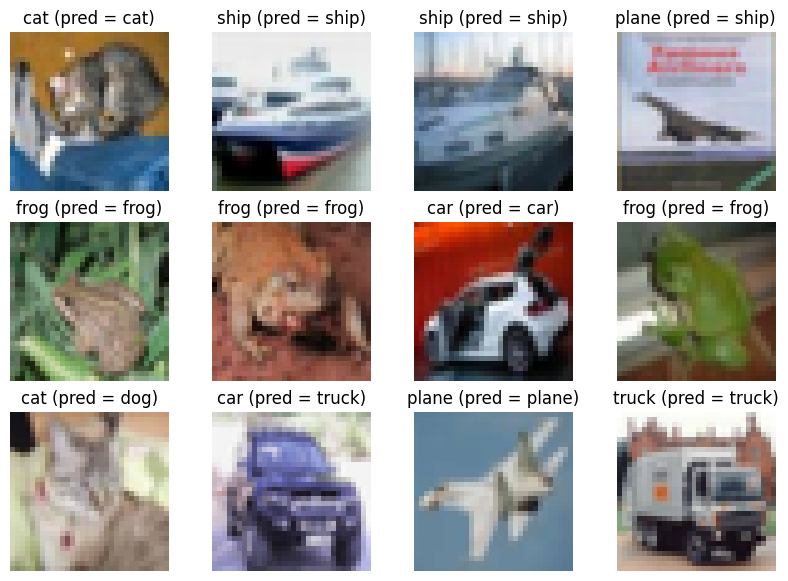

In [104]:
n_rows = 3

fig, axarr = plt.subplots(n_rows, batch_size, figsize = (10, 7))

tl = iter(testloader)

for i in range(n_rows):

    # returns batch_size images with their labels
    X, y = next(tl) 
    X, y = X.to(device), y.to(device)
    # get the predictions

    y_hat = model(X)
    _, pred_y = torch.max(y_hat.data, 1)

    # populate a row with the images in the batch
    for j in range(batch_size):
        img = np.moveaxis(X[j].to("cpu").numpy(), 0, 2) 
        axarr[i, j].imshow((img + 1)/2)
        axarr[i, j].axis("off")
        axarr[i, j].set(title = f"{classes[int(y[j])]} (pred = {classes[int(pred_y[j])]})")

As we observe, the model is right much more frequently than we would expect by chance, but still makes plenty of errors. 

## Inspecting Learned Features

It's possible to extract the outputs from intermediate layers of the model. Doing this can sometimes help us get some understanding of what features the model has learned from the data that help it to perform the classification task. It's important not to overinterpret these. 

The function below helps extract these hidden layer outputs. I retrieved this function from [this forum post](https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2). 

In [105]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [106]:
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

Let's pick an image and call our model on it to obtain an output. 

In [116]:
X, y = next(tl) 
X, y = X.to(device), y.to(device)

X = X[:1, :, :, :]
output = model(X)

Now let's visualize our image alongside activations from each of the two layers. 

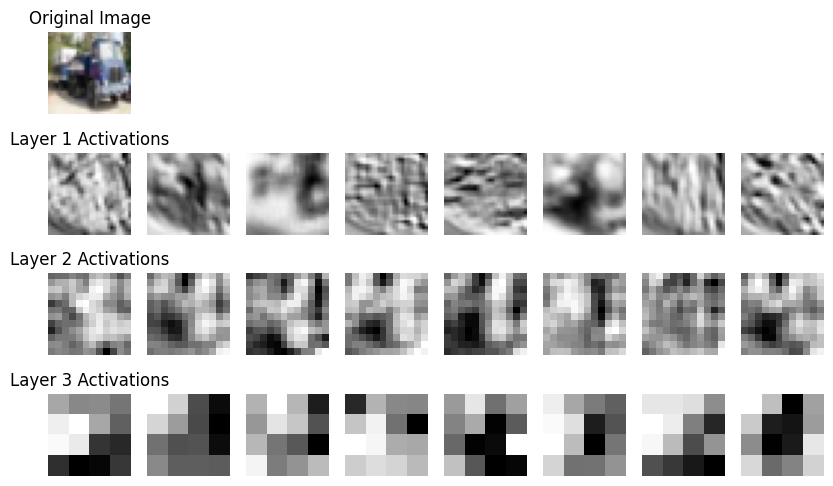

In [117]:
fig, axarr = plt.subplots(4, 8, figsize = (10, 6))

axarr[0, 0].imshow((np.moveaxis(X[0].to("cpu").numpy(), 0, 2) + 1) / 2)
axarr[0, 0].set_title("Original Image")

for ax in axarr.ravel():
    ax.axis("off")

for i in range(3):
    for j in range(8):

        layer = f"conv{i+1}"
        title = f"Layer {i+1} Activations"

        im_num = i*4 + j

        axarr[i+1, j].imshow(activation[layer].to("cpu").numpy()[0,im_num], cmap = "Greys")
        if j == 0:
            axarr[i+1, j].set_title(title)

Again, it's important not to read too much into these activations, but it can be fun to get a little peak into how the model "looks" at the data. 